In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
from cereeberus import ReebGraph, MapperGraph, Interleave, Assignment
import cereeberus.data.ex_mappergraphs as ex_mg

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import pandas as pd

import time
import random
from tqdm import tqdm
import itertools
from multiprocessing import Pool
import time
import numpy as np


## Optimize for different loop size without the distance matrix


In [3]:
def run_once(args):
    torus, line = args
    start = time.perf_counter()
    myInterleave = Interleave(torus, line)
    opt_start = time.perf_counter()
    myInterleave.fit()
    end = time.perf_counter()
    return (end - start, end - opt_start)


In [ ]:
total_time = []
optimization_time = []

# Warm-up run (avoid lazy init effects)
Interleave(ex_mg.torus(a=0, b=2, c=4, d=6, delta=1, seed=42), ex_mg.line(a=0, b=6, seed=0)).fit()


for i in tqdm(range(1,51)):
    torus = ex_mg.torus(a=0, b=2, c=i+2, d=i+4, delta=1, seed=4)
    line = ex_mg.line(a=0, b=i+4, seed=0)

    batch = [(torus, line)] * 10

    with Pool(processes=10) as pool:
        results = pool.map(run_once, batch)
                           

    total = [r[0] for r in results]
    opt = [r[1] for r in results]

    total_time.append((np.mean(total), np.std(total)))
    optimization_time.append((np.mean(opt), np.std(opt)))


100%|██████████| 50/50 [1:59:03<00:00, 142.87s/it]


ValueError: All arrays must be of the same length

In [5]:


df = pd.DataFrame({"loop_size": list(range(1,51)),
    "total_time_mean": [x[0] for x in total_time],
    "total_time_std": [x[1] for x in total_time],
    "optimization_time_mean": [x[0] for x in optimization_time],
    "optimization_time_std": [x[1] for x in optimization_time],
    })
df.to_csv("torus_line_benchmark_parallel.csv", index=False)


In [ ]:
total_time = []
optimization_time = []

# Warm-up run (avoid lazy init effects)
torus_warm = ex_mg.torus(a=0, b=2, c=4, d=6, delta=1, seed=42)
line_warm = ex_mg.line(a=0, b=6, seed=0)
warm = Interleave(torus_warm, line_warm)
warm.dist_fit()

for i in range(1,51):
    print(f"Benchmarking i={i}")
    torus = ex_mg.torus(a=0, b=2, c=i+2, d=i+4, delta=1, seed=42)
    line = ex_mg.line(a=0, b=i+4, seed=0)
     
    temp_total_time = []
    temp_optimization_time = []

    for j in range(10):
        start = time.perf_counter()
        myInt = Interleave(torus, line)
        opt_start = time.perf_counter()
        myInt.dist_fit()
        end = time.perf_counter()

        temp_total_time.append(end - start)
        temp_optimization_time.append(end - opt_start)

    total_time.append((np.mean(temp_total_time), np.std(temp_total_time)))
    optimization_time.append((np.mean(temp_optimization_time), np.std(temp_optimization_time)))

# export results as a csv
df = pd.DataFrame({"loop_size": list(range(1,51)),
    "total_time_mean": [x[0] for x in total_time],
    "total_time_std": [x[1] for x in total_time],
    "optimization_time_mean": [x[0] for x in optimization_time],
    "optimization_time_std": [x[1] for x in optimization_time],
    })
df.to_csv("torus_line_dist_benchmark.csv", index=False)


Benchmarking i=1
Benchmarking i=2
Benchmarking i=3
Benchmarking i=4
Benchmarking i=5
Benchmarking i=6
Benchmarking i=7
Benchmarking i=8
Benchmarking i=9
Benchmarking i=10
Benchmarking i=11
Benchmarking i=12
Benchmarking i=13
Benchmarking i=14
Benchmarking i=15
Benchmarking i=16
Benchmarking i=17
Benchmarking i=18
Benchmarking i=19
Benchmarking i=20
Benchmarking i=21
Benchmarking i=22
Benchmarking i=23
Benchmarking i=24
Benchmarking i=25
Benchmarking i=26
Benchmarking i=27
Benchmarking i=28
Benchmarking i=29
Benchmarking i=30
Benchmarking i=31
Benchmarking i=32
Benchmarking i=33
Benchmarking i=34
Benchmarking i=35
Benchmarking i=36
Benchmarking i=37
Benchmarking i=38
Benchmarking i=39
Benchmarking i=40
Benchmarking i=41
Benchmarking i=42
Benchmarking i=43
Benchmarking i=44
Benchmarking i=45
Benchmarking i=46
Benchmarking i=47
Benchmarking i=48
Benchmarking i=49
Benchmarking i=50


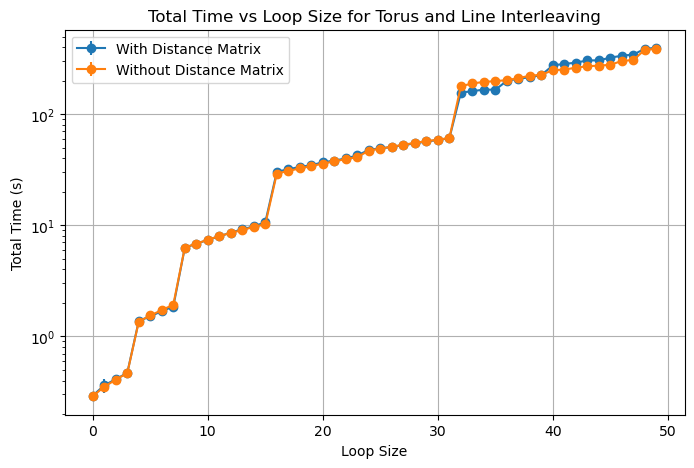

In [ ]:
# read from csv
df1 = pd.read_csv("torus_line_benchmark.csv")
df2 = pd.read_csv("torus_line_dist_benchmark.csv")

import matplotlib.pyplot as plt
import numpy as np
x = np.arange(len(total_time))
#unpack dist means and stds
dist_means, dist_stds = zip(*df2[["total_time_mean", "total_time_std"]].values)
means, stds = zip(*df1[["total_time_mean", "total_time_std"]].values)
plt.figure(figsize=(8,5))

plt.errorbar(x, means, yerr=stds, label='With Distance Matrix', fmt='-o')
plt.errorbar(x, dist_means, yerr=dist_stds, label='Without Distance Matrix', fmt='-o')
plt.xlabel('Loop Size')
plt.ylabel('Total Time (s)')
plt.title('Total Time vs Loop Size for Torus and Line Interleaving')
plt.legend()
plt.grid()
plt.yscale('log')
plt.savefig("torus_line_benchmark.png") 
